In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from PIL import Image
from numpy import asarray
import random
import os
import os.path
from os import path
import SimpleITK as sitk

In [2]:
kernel = np.zeros((21, 21))
kernel[11][11] = 1

In [3]:
temp = ndimage.distance_transform_edt(1-kernel)
kernel = np.exp( - temp** 2 )

(array([ 355.,  600.,  869., 1123., 1330., 1454., 1424., 1072.,  870.,
         578.,  325.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <a list of 11 Patch objects>)

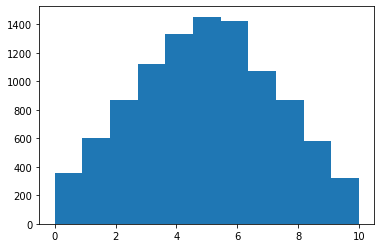

In [4]:
import scipy.stats as ss

r = np.arange(-5, 6)
rU, rL = r + 0.5, r - 0.5 
prob = ss.norm.cdf(rU, scale = 3) - ss.norm.cdf(rL, scale = 3)
prob = prob / prob.sum() #normalize the probabilities so their sum is 1
nums = np.random.choice(r, size = 10000, p = prob) + 5
plt.hist(nums, bins = len(r))

In [5]:
def generate_width(n,sigma=0.5, mu=1.5):
    low = random.randint(1,3)
    high = random.randint(5,8)
    nums = []
    nums.append(low)
    for i in range(1,n-1):
        nums.append(low+(high-low)/n*i)
    nums.append(high)
    noise = np.random.normal(mu, sigma, [1,len(nums)])
    for num in range(len(nums)):
        nums[num] = int(nums[num]+ noise[0][num])
        if nums[num] == 0:
            nums[num] = 1
    return nums

def generate_intensity(n,sigma=0.01, mu=0.1):
    high = round(random.uniform(0.3, 1.0), 10)
    low = round(random.uniform(0.05, 0.1), 10)
    nums = []
    nums.append(low)
    for i in range(1,n-1):
        nums.append(low+(high-low)/n*i)
    nums.append(high)
    noise = np.random.normal(mu, sigma, [1,len(nums)])
    for num in range(len(nums)):
        nums[num] = nums[num] + noise[0][num]
        if nums[num] > 1:
            nums[num] = 1
    return nums
     
def generate_kernel(w, intensity, sigma=0.1, mu=0.8, noise=0.05):
    kernel = np.zeros((2*w-1, 2*w-1))
    kernel[w-1][w-1] = 1
    temp = ndimage.distance_transform_edt(1-kernel)
    kernel = np.exp((-1/(8*w+1))*temp** 2)*intensity
#     kernel = kernel * (np.random.randn()*sigma + mu) + np.random.rand(2*w+1, 2*w+1)*noise
    return kernel

def comp(mat1, mat2): # compare kernel with the corresponding part of image
    return 1/2*(mat1+mat2+abs(mat1-mat2))


In [11]:
kernel=generate_kernel(5, 0.5, mu=0.8, sigma= 0.1)

In [14]:
sample = 10
start = -sample
x = np.arange(start,sample,.01)

In [15]:
num1 = 0
for a1 in np.arange(15,30,5):
    for a2 in np.arange(.02,.03,.01):
        for a3 in np.arange(1,50,10):
            for a4 in np.arange(-.5,.5,.5):
                for a5 in np.arange(-.5,.5,.5):
                    for a6 in np.arange(-.5,.5,.5):
                        for a7 in np.arange(-.5,.5,.5):
                            function_values = a1 * np.sin(a2 * x) + a3 * np.sin(0.7*x) + a4 * np.cos(a5 * x) + a6 * x + a7 * x**2
                            y = function_values
                            figure, b = plt.subplots()
                            plt.plot(x, y)
                            b.set_xlim(-10, 10)
                            b.set_ylim(-30, 30)
                            figure.set_size_inches(1.7, 1.7)
                            plt.axis('off')
                            plt.savefig("./single-origin/%d.png" % num1, dpi=100,bbox_inches='tight')
                            num1 = num1 + 1
                            plt.close()

In [16]:
for num in range(239):
    image = cv2.imread("./single-origin/%d.png" % num)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("./single-Sub-change/%d.png" % num, gray_image)
    px = np.array(Image.open("./single-Sub-change/%d.png" % num), np.float)
    # save x and y
    data=[]
    x = []
    y = []
    coverNum = np.zeros((len(px), len(px[0])))
    kernelSum = np.zeros((len(px), len(px[0])))
    for j in range(len(px[0])):
        for i in range(len(px)):
            if px[i,j] != 255:
                data.append([i,j])
    test = np.zeros((len(px), len(px[0])))
    for j in range(len(px[0])):
        for i in range(len(px)):
            if [i,j] in data:
                test[i][j] = 1
    for i in range(len(data)):
        x.append(data[i][1])
        y.append(data[i][0])
    n = len(x)
    widths = generate_width(n-20)
    intensity = generate_intensity(n-20)
    try:
        for i in range(10, len(y)-12):
            w1 = widths[i-10]
            intensity1 = intensity[i-10]
            dis = min(y[i],len(px)-y[i],x[i],len(px[0])-x[i])
            w = min(dis-1, w1)
            kernel = generate_kernel(w,intensity1,sigma=1,mu=5)
            coverNum[y[i]-w+1:y[i]+w, x[i]-w+1:x[i]+w] = coverNum[y[i]-w+1:y[i]+w, x[i]-w+1:x[i]+w]+1
            kernelBig = np.zeros((len(px), len(px[0])))
            kernelBig[y[i]-w+1:y[i]+w, x[i]-w+1:x[i]+w] = kernel
            kernelSum = kernelSum+kernelBig
        out = np.divide(kernelSum, coverNum, out=np.zeros_like(kernelSum), where=coverNum!=0)
        figure, b = plt.subplots()
        figure.set_size_inches(1.7, 1.7)
        plt.axis('off')
        plt.imshow(1-out, cmap='gray')
        plt.savefig("./single-Sub-change/%d.png" % num, dpi=100,pad_inches=0.0,bbox_inches='tight')
    except:
        print(error)
    plt.clf()
    plt.close()

In [17]:
# rotate
for num in range(239):
    img = Image.open("./single-Sub-change/%d.png" % num)
    img = img.resize((170,170)) 
    rotate = random.randint(0,360)
    img = img.rotate(rotate,fillcolor='white')
    img.save("./single-change/%d.png" % num,"PNG")
    img = Image.open("./single-origin/%d.png" % num)
    img = img.resize((170,170)) 
    img = img.rotate(rotate,fillcolor='white')
    img.save("./single-origin/%d.png" % num,"PNG")

In [18]:
# overlap
for numPics in range(5):
    selectList = []
    for l in range(3):
        select = random.randint(0,238)
        selectList.append(select)
    image_stack = []
    for i in range(len(selectList)):
        image = cv2.imread("./single-origin/%d.png" % selectList[i])
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_stack.append(gray_image)
    image_stack = np.stack(image_stack)
    image_mip = np.min(image_stack, axis=0)
    cv2.imwrite("./origin/%d.png" % numPics, image_mip)
    
    # change
    image_stack = []
    for i in range(len(selectList)):
        image = cv2.imread("./single-change/%d.png" % selectList[i])
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_stack.append(gray_image)
    image_stack = np.stack(image_stack)
    image_mip = np.min(image_stack, axis=0)
    cv2.imwrite("./change/%d.png" % numPics, image_mip)

In [26]:
# crop to train
file = open("train.txt","w")
for num in range(5):
    im1 = Image.open("./origin/%d.png" % num,"r")
    im2 = Image.open("./change/%d.png" % num, "r")
    count = 0
    for xAxis in range(0,151,3):
        for yAxix in range(0,151,3):
            imsub1 = im1.crop((xAxis, yAxix, xAxis+19, yAxix+19))
            imsub2 = im2.crop((xAxis, yAxix, xAxis+19, yAxix+19))
            imsub1.save("./origin-crop-new/%d-%d.png" % (num,count),"PNG")
            imsub2.save("./change-crop-new/%d-%d.png" % (num,count),"PNG")
            count = count+1
for a1 in range(4):
    emptyCount = 0
    for a2 in range(count):
        img = np.array(Image.open("./origin-crop-new/%d-%d.png" % (a1,a2)), np.float)
        pic = np.zeros((len(img), len(img[0])))
        px = []
        for j in range(len(img[0])):
            for i in range(len(img)):
                if img[i,j] < 250:
                    px.append([i,j])
        for j in range(len(img[0])):
            for i in range(len(img)):
                if [i,j] in px:
                    pic[i][j] = 1
        temp = ndimage.distance_transform_edt(1-pic)
        if temp[9][9] > 10:
            emptyCount = emptyCount + 1
            if emptyCount == 10:
#                 os.rename("./origin-crop-new/%d-%d.png"%(a1,a2),"./origin-crop-new/%d-%d.png----0.png"%(a1,a2))
#                 os.rename("./change-crop-new/%d-%d.png"%(a1,a2),"./change-crop-new/%d-%d.png----0.png"%(a1,a2))
                file.writelines("change-crop-new/%d-%d.png 0\n"%(a1,a2))
                emptyCount = 0
            else:
                os.remove("./origin-crop-new/%d-%d.png" % (a1,a2))
                os.remove("./change-crop-new/%d-%d.png" % (a1,a2))
        elif temp[9][9] < 2:
#             os.rename("./origin-crop-new/%d-%d.png"%(a1,a2),"./origin-crop-new/%d-%d.png----1.png"%(a1,a2))
#             os.rename("./change-crop-new/%d-%d.png"%(a1,a2),"./change-crop-new/%d-%d.png----1.png"%(a1,a2))
            file.writelines("change-crop-new/%d-%d.png 1\n"%(a1,a2))
        else:
#             os.rename("./origin-crop-new/%d-%d.png"%(a1,a2),"./origin-crop-new/%d-%d.png----0.png"%(a1,a2))
#             os.rename("./change-crop-new/%d-%d.png"%(a1,a2),"./change-crop-new/%d-%d.png----0.png"%(a1,a2))
            file.writelines("change-crop-new/%d-%d.png 0\n"%(a1,a2))

In [27]:
# crop to test
file = open("test.txt","w")
for a1 in range(4,5):
    emptyCount = 0
    for a2 in range(count):
        img = np.array(Image.open("./origin-crop-new/%d-%d.png" % (a1,a2)), np.float)
        pic = np.zeros((len(img), len(img[0])))
        px = []
        for j in range(len(img[0])):
            for i in range(len(img)):
                if img[i,j] < 250:
                    px.append([i,j])
        for j in range(len(img[0])):
            for i in range(len(img)):
                if [i,j] in px:
                    pic[i][j] = 1
        temp = ndimage.distance_transform_edt(1-pic)
        if temp[9][9] > 10:
            emptyCount = emptyCount + 1
            if emptyCount == 10:
#                 os.rename("./origin-crop-new/%d-%d.png"%(a1,a2),"./origin-crop-new/%d-%d.png----0.png"%(a1,a2))
#                 os.rename("./change-crop-new/%d-%d.png"%(a1,a2),"./change-crop-new/%d-%d.png----0.png"%(a1,a2))
                file.writelines("change-crop-new/%d-%d.png 0\n"%(a1,a2))
                emptyCount = 0
            else:
                os.remove("./origin-crop-new/%d-%d.png" % (a1,a2))
                os.remove("./change-crop-new/%d-%d.png" % (a1,a2))
        elif temp[9][9] < 2:
#             os.rename("./origin-crop-new/%d-%d.png"%(a1,a2),"./origin-crop-new/%d-%d.png----1.png"%(a1,a2))
#             os.rename("./change-crop-new/%d-%d.png"%(a1,a2),"./change-crop-new/%d-%d.png----1.png"%(a1,a2))
            file.writelines("change-crop-new/%d-%d.png 1\n"%(a1,a2))
        else:
#             os.rename("./origin-crop-new/%d-%d.png"%(a1,a2),"./origin-crop-new/%d-%d.png----0.png"%(a1,a2))
#             os.rename("./change-crop-new/%d-%d.png"%(a1,a2),"./change-crop-new/%d-%d.png----0.png"%(a1,a2))
            file.writelines("change-crop-new/%d-%d.png 0\n"%(a1,a2))